In [17]:
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
import pandas as pd
import pendulum
from greenflow.g import g
from tinydb import TinyDB, Query
from os import getenv
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in the 'redpanda_kafka_data' DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import greenflow.analysis as an
import qgrid

In [18]:
experiments = {exp.doc_id: exp for exp in g.storage.experiments.all()}

def sort_by_time(exp_id):
    date_time_str = experiments[exp_id]["started_ts"]
    return pendulum.parse(date_time_str)

In [19]:
exp_ids = sorted(
    experiments.keys(),
    key=sort_by_time,
    reverse=True,
)
results = []
cutoff = "2024-06-25T19:44:26.378015+02:00"

for index, _ in enumerate(exp_ids):
    current = exp_ids[index]
    started_ts_string = experiments[current]["started_ts"]
    stopped_ts_string = experiments[current]["stopped_ts"]
    started_ts = pendulum.parse(started_ts_string)
    stopped_ts = pendulum.parse(stopped_ts_string)
    metadata = experiments[current]["experiment_metadata"]
    params = dict(**metadata["factors"]["exp_params"])
    # select just the relevant params - load, instances, durationSeconds
    params = {
        k: v
        for k, v in params.items()
        if k
        in [
            "load",
            # "instances",
            "durationSeconds",
            "messageSize",
            # "partitions",
            # "replicationFactor",
            # "redpanda_write_caching",
        ]
    }
    if "results" in metadata:
        result = metadata["results"]
    else:
        result = {}
    current_result = {
        "exp_id": current,
        "exp_name": experiments[current]["exp_name"],
        "exp_description": experiments[current]["experiment_description"],
        "started_ts": started_ts_string,
        "stopped_ts": stopped_ts_string,
        # "duration_from_ts": stopped_ts.diff(started_ts).in_seconds(),
        # "dashboard_url": metadata["dashboard_url"],
        **result,
        **params,
    }

    if started_ts >= pendulum.parse(cutoff):
        if "Warmup" not in current_result["exp_description"]:
            if "Montcalm" in current_result["exp_description"]:
                if current_result["messageSize"] in [128, 512, 1024, 4096, 10240]:
                    if "proportionality" in current_result["exp_description"]:
                        results.append(current_result)

results = pd.DataFrame(results)
# results = results[results["redpanda_write_caching"] ==True]
# Reindex with exp_id
results = results.set_index("exp_id")
# print(results[:25].to_csv())
redpanda_kafka_data = results

qgrid_widget = qgrid.show_grid(redpanda_kafka_data, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [20]:
redpanda_kafka_data = qgrid_widget.get_changed_df()

In [21]:
# redpanda_kafka_data = qgrid_widget.get_changed_df()
prom = an.prom

def enrich_dataframe(df):
    # Calculate observed throughput for each row
    df = df.apply(an.calculate_observed_throughput, axis=1)

    # # Calculate throughput gap for each row
    df = df.apply(an.calculate_throughput_gap, axis=1)

    df = df.apply(an.calculate_latency, axis=1)
    df = df.apply(an.calculate_average_power, axis=1)
    df = df.apply(an.calculate_throughput_per_watt, axis=1)
    df = df.apply(an.calculate_throughput_MBps, axis=1)

    return df

redpanda_kafka_data = enrich_dataframe(redpanda_kafka_data)


In [22]:

# Display DataFrame using qgrid
qgrid_widget = qgrid.show_grid(redpanda_kafka_data, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

redpanda_kafka_data = qgrid_widget.get_changed_df()

# Set the threshold for significantly lower throughput
throughput_threshold = -20
latency_threshold = 1.5


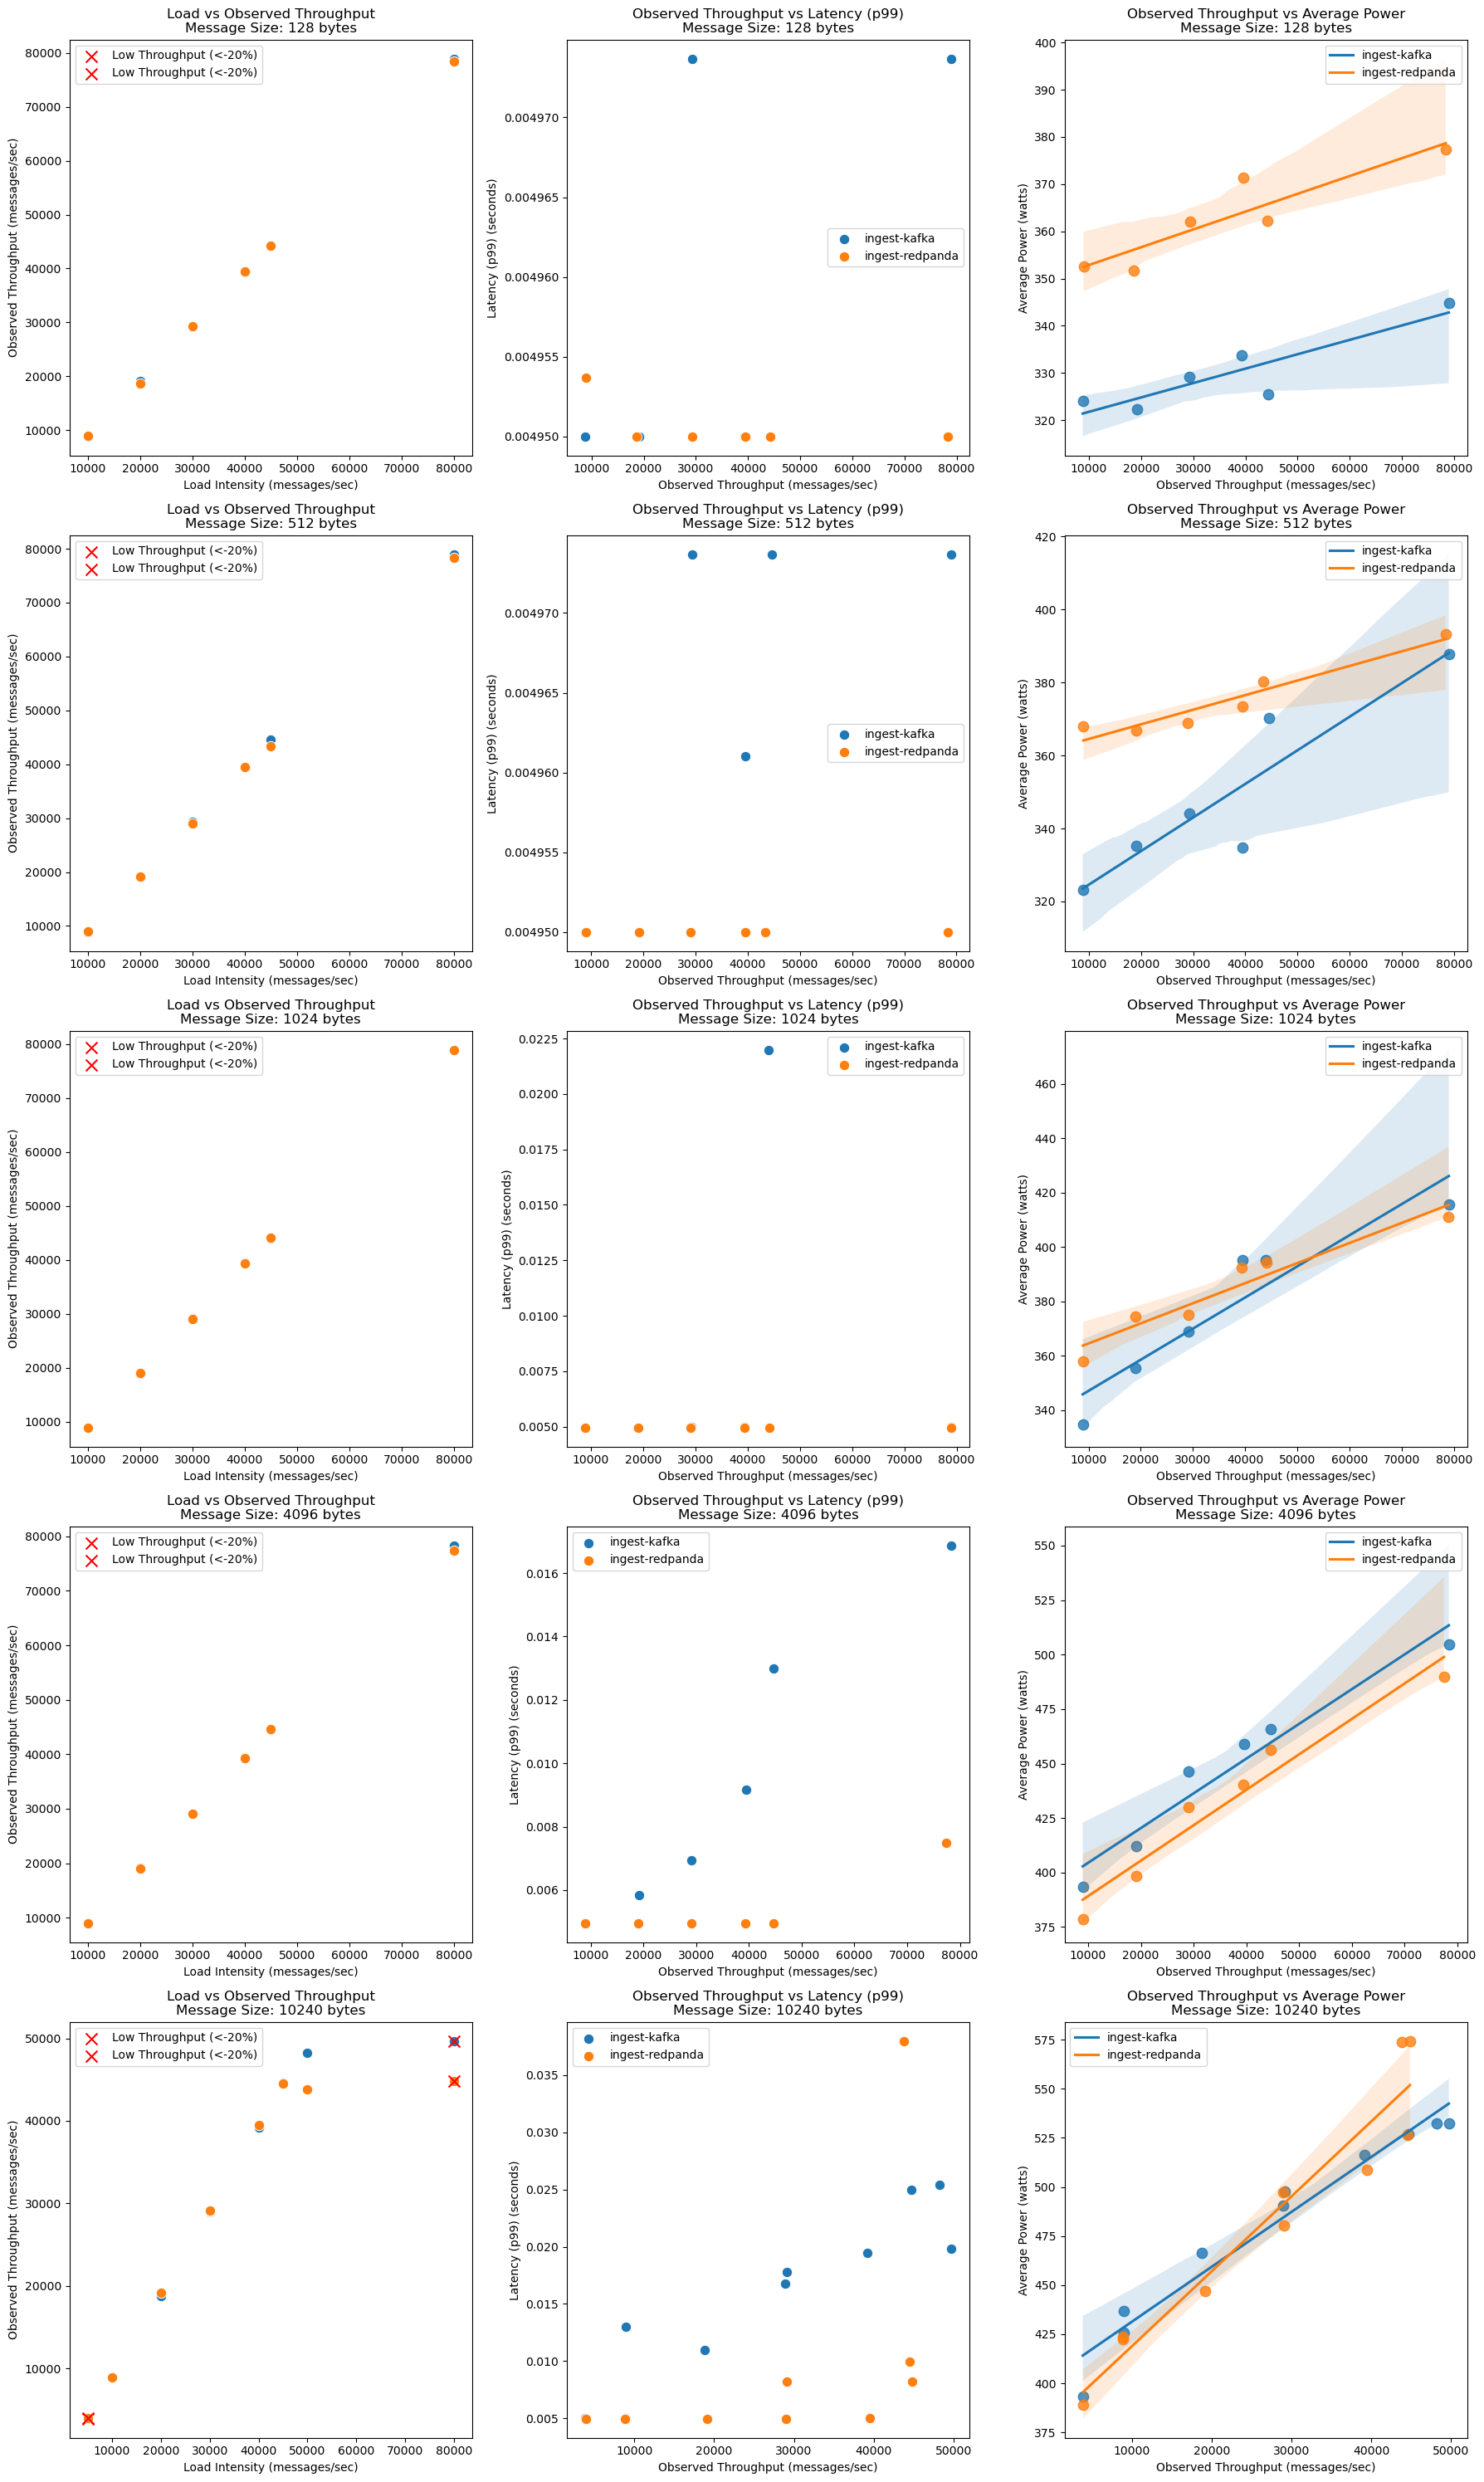

In [24]:

# Get unique message sizes
message_sizes = redpanda_kafka_data['messageSize'].unique()
message_sizes.sort()

# Create a figure with subplots for each message size
fig, axs = plt.subplots(len(message_sizes), 3, figsize=(18, 6 * len(message_sizes)))

for j, message_size in enumerate(message_sizes):
    # Filter data by message size
    size_data = redpanda_kafka_data[redpanda_kafka_data['messageSize'] == message_size]
    
    # Plot load vs observed throughput
    for i, exp_name in enumerate(['ingest-kafka', 'ingest-redpanda']):
        data = size_data[size_data['exp_name'] == exp_name]
        sns.scatterplot(x='load', y='observed_throughput', data=data, 
                        s=80, ax=axs[j, 0])
        
        # Highlight instances with significantly lower throughput
        low_throughput = data[data['throughput_gap_percentage'] < throughput_threshold]
        axs[j, 0].scatter(x=low_throughput['load'], y=low_throughput['observed_throughput'], 
                          color='red', marker='x', s=100, label=f'Low Throughput (<{throughput_threshold}%)')

    axs[j, 0].set_title(f'Load vs Observed Throughput\nMessage Size: {message_size} bytes')
    axs[j, 0].set_xlabel('Load Intensity (messages/sec)')
    axs[j, 0].set_ylabel('Observed Throughput (messages/sec)')
    axs[j, 0].legend()

    # Filter out instances with significantly lower throughput or higher latency for each experiment and message size
    filtered_data = {}
    for exp_name in ['ingest-kafka', 'ingest-redpanda']:
        filtered_data[exp_name] = size_data[size_data['exp_name'] == exp_name]
    # for exp_name in ['ingest-kafka', 'ingest-redpanda']:
    #     filtered_data[exp_name] = size_data[
    #         (size_data['exp_name'] == exp_name) &
    #         (size_data['throughput_gap_percentage'] >= throughput_threshold) &
    #         (size_data['latency_p99'] <= latency_threshold)
    #     ]

    # Plot observed throughput vs latency (filtered data)
    for i, exp_name in enumerate(['ingest-kafka', 'ingest-redpanda']):
        data = filtered_data[exp_name]
        sns.scatterplot(x='observed_throughput', y='latency_p99', data=data, 
                        s=80, ax=axs[j, 1], label=exp_name)

    axs[j, 1].set_title(f'Observed Throughput vs Latency (p99)\nMessage Size: {message_size} bytes')
    axs[j, 1].set_xlabel('Observed Throughput (messages/sec)')
    axs[j, 1].set_ylabel('Latency (p99) (seconds)')
    axs[j, 1].legend()

    # Plot observed throughput vs average power (filtered data)
    for i, exp_name in enumerate(['ingest-kafka', 'ingest-redpanda']):
        data = filtered_data[exp_name]
        sns.regplot(x='observed_throughput', y='average_power', data=data, 
                    scatter_kws={'s': 80}, line_kws={'label': exp_name}, ax=axs[j, 2])

    axs[j, 2].set_title(f'Observed Throughput vs Average Power\nMessage Size: {message_size} bytes')
    axs[j, 2].set_xlabel('Observed Throughput (messages/sec)')
    axs[j, 2].set_ylabel('Average Power (watts)')
    axs[j, 2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
